Paper1: Practical Deep Reinforcement Learning Approach for
Stock Trading  

Paper2: Deep Reinforcement Learning for Automated Stock Trading:
An Ensemble Strategy

code:  

https://github.com/AI4Finance-Foundation/FinRL/blob/master/examples/Stock_NeurIPS2018_SB3.ipynb

https://github.com/AI4Finance-Foundation/FinRL/blob/master/examples/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb

# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train Agents](#5)
* [7. Backtesting Performance](#6)  
  

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
!pip install pyportfolioopt
!pip install stable-baselines3
!pip install pyfolio
!pip install yfinance
!pip install stockstats
!pip install alpaca_trade_api
!pip install wrds
!pip install pytz
!pip install exchange_calendars
!pip install numpy==1.24.4


<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Comp579_Project')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

from models.DRLAgent import DRLAgent
from models.DRLEnsembleAgent import DRLEnsembleAgent
from utils.config_tickers import DOW_30_TICKER
from preprocessor.yahoodownloader import YahooDownloader
from preprocessor.preprocessors import FeatureEngineer, data_split
from env_stock_trading.env_stocktrading import StockTradingEnv
from utils.plot import backtest_stats, get_baseline
from stable_baselines3.common.logger import configure
from data_processors.data_processor import DataProcessor

from pprint import pprint
import itertools

/usr/local/lib/python3.10/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
from utils.funcs import check_and_make_directories

# create folders for 5 agents
from utils.config_agent import (
    DATA_SAVE_DIR_AGENTS,
    TRAINED_MODEL_DIR_AGENTS,
    TENSORBOARD_LOG_DIR_AGENTS,
    RESULTS_DIR_AGENTS,
    INDICATORS,
)
check_and_make_directories([DATA_SAVE_DIR_AGENTS, TRAINED_MODEL_DIR_AGENTS, TENSORBOARD_LOG_DIR_AGENTS, RESULTS_DIR_AGENTS])

# create folders for ensemble strategy
from utils.config_ensemble_strategy import (
    DATA_SAVE_DIR_ENSEMBLE,
    TRAINED_MODEL_DIR_ENSEMBLE,
    TENSORBOARD_LOG_DIR_ENSEMBLE,
    RESULTS_DIR_ENSEMBLE
)

check_and_make_directories([DATA_SAVE_DIR_ENSEMBLE, TRAINED_MODEL_DIR_ENSEMBLE, TENSORBOARD_LOG_DIR_ENSEMBLE, RESULTS_DIR_ENSEMBLE])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [4]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2015-09-30'

TRADE_START_DATE = '2015-10-01'
TRADE_END_DATE = '2021-01-01'

In [ ]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

In [6]:
df.sort_values(['date','tic'],ignore_index=True).head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:75: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(column):


,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.743888,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,42.406387,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.098138,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,30.950020,7117200,CAT,4


In [7]:
df1 = df.copy()
df2 = df.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [8]:
fe1 = FeatureEngineer(use_technical_indicator=True,
                      tech_indicator_list = INDICATORS,
                      use_turbulence=True,
                      # use_vix=True,
                      user_defined_feature = False)

processed1 = fe1.preprocess_data(df1)
processed1 = processed1.copy()
processed1 = processed1.fillna(0)
processed_data_5agents = processed1.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [9]:
processed_data_5agents.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(87609, 17)

In [10]:
processed_data_5agents.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
87604,2020-12-31,345.040009,351.089996,344.049988,335.059784,1969000,UNH,3,1.938241,336.808713,317.469366,57.805697,104.064343,16.532806,325.466050,320.810494,8.377085
87605,2020-12-31,218.399994,219.820007,216.199997,213.664169,5922200,V,3,2.197213,212.966499,198.174635,59.436993,232.365219,17.800675,205.124311,199.932853,8.377085
87606,2020-12-31,58.060001,58.799999,58.020000,48.038685,12906300,VZ,3,-0.338566,50.893837,47.250631,46.770796,-157.156754,5.474821,49.198703,48.552899,8.377085
87607,2020-12-31,39.330002,40.000000,39.029999,33.866364,7696000,WBA,3,0.007662,36.824057,32.652954,51.531855,-23.529556,5.653153,34.042722,32.855325,8.377085
87608,2020-12-31,48.066666,48.090000,47.616669,45.710594,17814000,WMT,3,-0.271788,47.378995,45.178057,49.322014,-105.886467,3.525909,46.787998,46.158788,8.377085


In [11]:
# for ensemble strategy, just add turbulence
fe2 = FeatureEngineer(use_technical_indicator=True,
                      tech_indicator_list = INDICATORS,
                      use_turbulence=True,
                      user_defined_feature = False)

processed2 = fe2.preprocess_data(df2)
processed2 = processed2.copy()
processed2 = processed2.fillna(0)
processed_data_ensemble = processed2.replace(np.inf,0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Successfully added technical indicators
Successfully added turbulence index


In [12]:
processed_data_ensemble.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(87609, 17)

In [13]:
processed_data_ensemble.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
87604,2020-12-31,345.040009,351.089996,344.049988,335.059784,1969000,UNH,3,1.938241,336.808713,317.469366,57.805697,104.064343,16.532806,325.466050,320.810494,8.377085
87605,2020-12-31,218.399994,219.820007,216.199997,213.664169,5922200,V,3,2.197213,212.966499,198.174635,59.436993,232.365219,17.800675,205.124311,199.932853,8.377085
87606,2020-12-31,58.060001,58.799999,58.020000,48.038685,12906300,VZ,3,-0.338566,50.893837,47.250631,46.770796,-157.156754,5.474821,49.198703,48.552899,8.377085
87607,2020-12-31,39.330002,40.000000,39.029999,33.866364,7696000,WBA,3,0.007662,36.824057,32.652954,51.531855,-23.529556,5.653153,34.042722,32.855325,8.377085
87608,2020-12-31,48.066666,48.090000,47.616669,45.710594,17814000,WMT,3,-0.271788,47.378995,45.178057,49.322014,-105.886467,3.525909,46.787998,46.158788,8.377085


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period:

Trading data period:


In [14]:
train_5agents = data_split(processed_data_5agents, TRAIN_START_DATE, TRAIN_END_DATE)
trade_5agents = data_split(processed_data_5agents, TRADE_START_DATE, TRADE_END_DATE)
print(len(train_5agents))
print(len(trade_5agents))

49213
38367


In [15]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

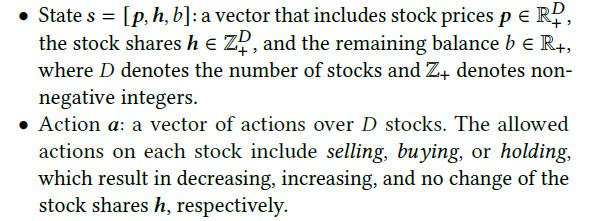

In [16]:
# these params are for 5 agents + ensemble strategy
stock_dimension = len(trade_5agents.tic.unique())

state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


## Part 5.1: Environment for 5 Agents

In [17]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs_agents = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "results_dir":  RESULTS_DIR_AGENTS
}

e_train_gym_5agents = StockTradingEnv(df = train_5agents, **env_kwargs_agents)

In [18]:
len(e_train_gym_5agents.state)

291

In [19]:
env_train_5agents, _ = e_train_gym_5agents.get_sb_env()
print(type(env_train_5agents))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [20]:
# exactly the same env as ensemble strategy
e_trade_gym_5agents = StockTradingEnv(df = trade_5agents,
                                      # turbulence_threshold = 70,
                                      # risk_indicator_col='vix',
                                      **env_kwargs_agents)

## Part 5.2: Environment for Ensemble Strategy

In [21]:
# rebalance_window is the number of days to retrain the model
rebalance_window = 63
# validation_window is the number of days to do validation and trading
# (e.g. if validation_window=63, then both validation and trading period will be 63 days)
validation_window = 63

env_kwargs_ensemble = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5,
    "results_dir": RESULTS_DIR_ENSEMBLE
}

ensemble_agent = DRLEnsembleAgent(df=processed_data_ensemble,
                 train_period=(TRAIN_START_DATE, TRAIN_END_DATE),
                 val_test_period=(TRADE_START_DATE, TRADE_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs_ensemble)


<a id='5'></a>
# Part 6: Train DRL Agents


## Part 6.1: 5 Agents

In [22]:
agent = DRLAgent(env = env_train_5agents)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

### Agent 1: A2C


In [23]:
agent = DRLAgent(env = env_train_5agents)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = DATA_SAVE_DIR_AGENTS + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to datasets_agents/a2c


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=50000) if if_using_a2c else None

In [25]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
        model=trained_a2c,
        environment = e_trade_gym_5agents)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


hit end!


In [26]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
df_result_a2c.to_csv("{}/account_value_{}.csv".format(RESULTS_DIR_AGENTS, 'a2c'), index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Agent 2: DDPG

In [27]:
agent = DRLAgent(env = env_train_5agents)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = DATA_SAVE_DIR_AGENTS + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to datasets_agents/ddpg


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg,
                                 tb_log_name='ddpg',
                                 total_timesteps=50000) if if_using_ddpg else None

In [29]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym_5agents)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


hit end!


In [30]:
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_ddpg.to_csv("{}/account_value_{}.csv".format(RESULTS_DIR_AGENTS, 'ddpg'),index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Agent 3: PPO

In [31]:
agent = DRLAgent(env = env_train_5agents)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = DATA_SAVE_DIR_AGENTS + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to datasets_agents/ppo


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                                tb_log_name='ppo',
                                total_timesteps=50000) if if_using_ppo else None

In [33]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym_5agents)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


hit end!


In [34]:
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
df_result_ppo.to_csv("{}/account_value_{}.csv".format(RESULTS_DIR_AGENTS, 'ppo'),index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Agent 4: TD3

In [35]:
agent = DRLAgent(env = env_train_5agents)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = DATA_SAVE_DIR_AGENTS + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Logging to datasets_agents/td3


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                                tb_log_name='td3',
                                total_timesteps=50000) if if_using_td3 else None

In [37]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym_5agents)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


hit end!


In [38]:
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_td3.rename(columns = {'account_value':'td3'}, inplace = True)
df_result_ddpg.to_csv("{}/account_value_{}.csv".format(RESULTS_DIR_AGENTS, 'td3'),index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Agent 5: SAC

In [39]:
agent = DRLAgent(env = env_train_5agents)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac", model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = DATA_SAVE_DIR_AGENTS + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to datasets_agents/sac


In [ ]:
trained_sac = agent.train_model(model=model_sac,
                                tb_log_name='sac',
                                total_timesteps=50000) if if_using_sac else None

In [41]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym_5agents)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


hit end!


In [42]:
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_result_sac.rename(columns = {'account_value':'sac'}, inplace = True)
df_result_sac.to_csv("{}/account_value_{}.csv".format(RESULTS_DIR_AGENTS, 'sac'),index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['dji_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs_agents["initial_amount"]
df_dji = df_dji.set_index(df_dji.columns[0])

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (1323, 8)
Annual return          0.127876
Cumulative returns     0.880928
Annual volatility      0.199160
Sharpe ratio           0.705053
Calmar ratio           0.344808
Stability              0.822474
Max drawdown          -0.370862
Omega ratio            1.165017
Sortino ratio          0.972446
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.894816
Daily value at risk   -0.024535
dtype: float64


In [45]:
DRLagents_result = pd.DataFrame()
DRLagents_result = pd.merge(DRLagents_result, df_result_a2c, how='outer', left_index=True, right_index=True)
DRLagents_result = pd.merge(DRLagents_result, df_result_ddpg, how='outer', left_index=True, right_index=True)
DRLagents_result = pd.merge(DRLagents_result, df_result_td3, how='outer', left_index=True, right_index=True)
DRLagents_result = pd.merge(DRLagents_result, df_result_ppo, how='outer', left_index=True, right_index=True)
DRLagents_result = pd.merge(DRLagents_result, df_result_sac, how='outer', left_index=True, right_index=True)
DRLagents_result = pd.merge(DRLagents_result, df_dji, how='outer', left_index=True, right_index=True)

DRLagents_result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,a2c,ddpg,td3,ppo,sac,dji_value
date,,,,,,
2015-10-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2015-10-02,1.001209e+06,1.000772e+06,1.000873e+06,1.000250e+06,1.001125e+06,1.012313e+06
2015-10-05,1.004720e+06,1.004045e+06,1.003593e+06,1.000854e+06,1.004236e+06,1.030999e+06
2015-10-06,1.002121e+06,1.002781e+06,1.001329e+06,1.000450e+06,1.003235e+06,1.031845e+06
2015-10-07,1.007348e+06,1.005391e+06,1.006051e+06,1.001302e+06,1.006247e+06,1.039349e+06
...,...,...,...,...,...,...
2020-12-24,1.991795e+06,2.125246e+06,1.962952e+06,1.816622e+06,2.085500e+06,1.855940e+06
2020-12-28,2.002708e+06,2.151876e+06,1.977992e+06,1.829953e+06,2.104938e+06,1.868483e+06
2020-12-29,2.000625e+06,2.146199e+06,1.976967e+06,1.825872e+06,2.100901e+06,1.864285e+06


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1500x500 with 0 Axes>

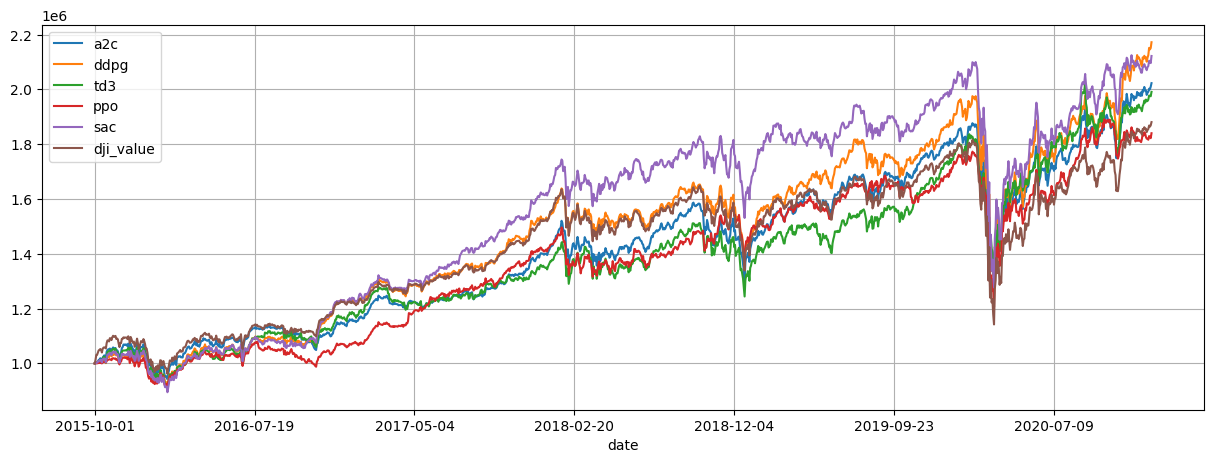

In [46]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
DRLagents_result.plot(grid=True);

In [47]:
DRLagents_result.to_csv("DRLagents_result_ver0.csv")

## Part 6.2: Ensemble Strategy

In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

df_summary_ensemble_agent = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                                 PPO_model_kwargs,
                                                                 DDPG_model_kwargs,
                                                                 None, #SAC_model_kwargs,
                                                                 None, #TD3_model_kwargs,
                                                                 timesteps_dict)

In [49]:
df_summary_ensemble_agent

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2015-10-02,2016-01-04,DDPG,-0.054488,0.02368,0.036548,None,None
1,189,2016-01-04,2016-04-05,DDPG,0.211495,0.108339,0.269179,None,None
2,252,2016-04-05,2016-07-05,A2C,0.10764,0.03065,0.013635,None,None
3,315,2016-07-05,2016-10-03,DDPG,-0.021872,-0.036553,0.025405,None,None
4,378,2016-10-03,2017-01-03,DDPG,0.431333,0.083158,0.487146,None,None
5,441,2017-01-03,2017-04-04,A2C,0.505236,0.136937,0.503833,None,None
6,504,2017-04-04,2017-07-05,DDPG,0.222671,0.048155,0.226436,None,None
7,567,2017-07-05,2017-10-03,PPO,0.111635,0.333443,0.332811,None,None
8,630,2017-10-03,2018-01-03,DDPG,0.595559,0.310462,0.610453,None,None
9,693,2018-01-03,2018-04-05,A2C,-0.073479,-0.195639,-0.076563,None,None


In [50]:
df_summary_ensemble_agent.to_csv("df_summary_ensemble_agent.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

## Part 7.1: 5 Agents

In [51]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['dji_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs_agents["initial_amount"]
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (1323, 8)
Annual return          0.127876
Cumulative returns     0.880928
Annual volatility      0.199160
Sharpe ratio           0.705053
Calmar ratio           0.344808
Stability              0.822474
Max drawdown          -0.370862
Omega ratio            1.165017
Sortino ratio          0.972446
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.894816
Daily value at risk   -0.024535
dtype: float64


,dji_value
date,
2015-10-01,1.000000e+06
2015-10-02,1.012313e+06
2015-10-05,1.030999e+06
2015-10-06,1.031845e+06
2015-10-07,1.039349e+06
...,...
2020-12-24,1.855940e+06
2020-12-28,1.868483e+06
2020-12-29,1.864285e+06


In [52]:
df_dji.to_csv("df_dji.csv")

In [53]:
DRLagents_result = pd.DataFrame()
DRLagents_result = pd.merge(DRLagents_result, df_result_a2c, how='outer', left_index=True, right_index=True)
DRLagents_result = pd.merge(DRLagents_result, df_result_ddpg, how='outer', left_index=True, right_index=True)
DRLagents_result = pd.merge(DRLagents_result, df_result_td3, how='outer', left_index=True, right_index=True)
DRLagents_result = pd.merge(DRLagents_result, df_result_ppo, how='outer', left_index=True, right_index=True)
DRLagents_result = pd.merge(DRLagents_result, df_result_sac, how='outer', left_index=True, right_index=True)
DRLagents_result = pd.merge(DRLagents_result, df_dji, how='outer', left_index=True, right_index=True)

DRLagents_result

,a2c,ddpg,td3,ppo,sac,dji_value
date,,,,,,
2015-10-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2015-10-02,1.001209e+06,1.000772e+06,1.000873e+06,1.000250e+06,1.001125e+06,1.012313e+06
2015-10-05,1.004720e+06,1.004045e+06,1.003593e+06,1.000854e+06,1.004236e+06,1.030999e+06
2015-10-06,1.002121e+06,1.002781e+06,1.001329e+06,1.000450e+06,1.003235e+06,1.031845e+06
2015-10-07,1.007348e+06,1.005391e+06,1.006051e+06,1.001302e+06,1.006247e+06,1.039349e+06
...,...,...,...,...,...,...
2020-12-24,1.991795e+06,2.125246e+06,1.962952e+06,1.816622e+06,2.085500e+06,1.855940e+06
2020-12-28,2.002708e+06,2.151876e+06,1.977992e+06,1.829953e+06,2.104938e+06,1.868483e+06
2020-12-29,2.000625e+06,2.146199e+06,1.976967e+06,1.825872e+06,2.100901e+06,1.864285e+06


In [54]:
DRLagents_result.to_csv("{}/{}.csv".format(RESULTS_DIR_AGENTS, 'DRL_5agents_result'))

In [55]:
DRLagents_result

,a2c,ddpg,td3,ppo,sac,dji_value
date,,,,,,
2015-10-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2015-10-02,1.001209e+06,1.000772e+06,1.000873e+06,1.000250e+06,1.001125e+06,1.012313e+06
2015-10-05,1.004720e+06,1.004045e+06,1.003593e+06,1.000854e+06,1.004236e+06,1.030999e+06
2015-10-06,1.002121e+06,1.002781e+06,1.001329e+06,1.000450e+06,1.003235e+06,1.031845e+06
2015-10-07,1.007348e+06,1.005391e+06,1.006051e+06,1.001302e+06,1.006247e+06,1.039349e+06
...,...,...,...,...,...,...
2020-12-24,1.991795e+06,2.125246e+06,1.962952e+06,1.816622e+06,2.085500e+06,1.855940e+06
2020-12-28,2.002708e+06,2.151876e+06,1.977992e+06,1.829953e+06,2.104938e+06,1.868483e+06
2020-12-29,2.000625e+06,2.146199e+06,1.976967e+06,1.825872e+06,2.100901e+06,1.864285e+06


## Part 7.2: Ensemble Strategy

In [79]:
unique_trade_date = processed_data_ensemble[(processed_data_ensemble.date > TRADE_START_DATE)&(processed_data_ensemble.date <= TRADE_END_DATE)].date.unique()
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value_ensemble = pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1, rebalance_window):
    temp = pd.read_csv('results_ensemble_strategy/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value_ensemble = pd.concat([df_account_value_ensemble, temp],ignore_index=True)

sharpe = (252**0.5)*df_account_value_ensemble.account_value.pct_change(1).mean()/df_account_value_ensemble.account_value.pct_change(1).std()
print('Sharpe Ratio: ', sharpe)

Sharpe Ratio:  0.9328532791850289


In [83]:
df_account_value_ensemble=df_account_value_ensemble.join(df_trade_date[validation_window:].reset_index(drop=True))

In [84]:
df_account_value_ensemble

,account_value,date,daily_return,datadate
0,1.000000e+06,2016-01-04,NaN,2016-01-04
1,9.996816e+05,2016-01-05,-0.000318,2016-01-05
2,9.962764e+05,2016-01-06,-0.003406,2016-01-06
3,9.876784e+05,2016-01-07,-0.008630,2016-01-07
4,9.839585e+05,2016-01-08,-0.003766,2016-01-08
...,...,...,...,...
1192,1.627423e+06,2020-09-28,0.010321,2020-09-28
1193,1.621927e+06,2020-09-29,-0.003377,2020-09-29
1194,1.632037e+06,2020-09-30,0.006233,2020-09-30
1195,1.632840e+06,2020-10-01,0.000492,2020-10-01


In [60]:
# BackTestStats

print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ensemble)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.107824
Cumulative returns     0.626436
Annual volatility      0.117270
Sharpe ratio           0.932853
Calmar ratio           1.012062
Stability              0.923838
Max drawdown          -0.106539
Omega ratio            1.191563
Sortino ratio          1.298719
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.016625
Daily value at risk   -0.014341
dtype: float64


## Part 7.3: Combine all the results

In [85]:
min_date = df_account_value_ensemble.datadate.unique()[0]
max_date = df_account_value_ensemble.datadate.unique()[-1]

In [86]:
DRLagents_result_new = DRLagents_result.reset_index()
selected_data_DRLagents = DRLagents_result_new[(DRLagents_result_new.date >= min_date)&(DRLagents_result_new.date <= max_date)]
selected_data_DRLagents.reset_index(drop=True, inplace=True)
selected_data_DRLagents

,date,a2c,ddpg,td3,ppo,sac,dji_value
0,2016-01-04,1.033691e+06,1.004436e+06,1.020671e+06,9.847727e+05,1.013727e+06,1.053892e+06
1,2016-01-05,1.034201e+06,1.004157e+06,1.016502e+06,9.854274e+05,1.012913e+06,1.054489e+06
2,2016-01-06,1.023894e+06,9.907115e+05,1.003490e+06,9.711103e+05,9.968102e+05,1.038993e+06
3,2016-01-07,1.003438e+06,9.681206e+05,9.838057e+05,9.526398e+05,9.715451e+05,1.014878e+06
4,2016-01-08,9.923128e+05,9.604194e+05,9.747892e+05,9.446105e+05,9.613729e+05,1.004575e+06
...,...,...,...,...,...,...,...
1192,2020-09-28,1.833265e+06,1.875524e+06,1.890595e+06,1.836310e+06,1.975968e+06,1.695185e+06
1193,2020-09-29,1.830158e+06,1.864784e+06,1.882901e+06,1.829641e+06,1.967298e+06,1.687109e+06
1194,2020-09-30,1.847601e+06,1.887880e+06,1.912200e+06,1.842552e+06,1.995729e+06,1.707331e+06
1195,2020-10-01,1.853079e+06,1.892148e+06,1.913605e+06,1.844255e+06,1.997980e+06,1.709494e+06


In [87]:
# rebase 1.000000e+06 as starting value
new_data_DRLagents = pd.DataFrame()
new_data_DRLagents['date'] = selected_data_DRLagents['date']

for method in ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'dji_value']:
    method_return = selected_data_DRLagents[method].pct_change()
    cumulative_returns = (1 + method_return).cumprod()
    cumulative_returns[0] = 1
    new_data_DRLagents[method] = cumulative_returns * 1.000000e+06

In [88]:
new_data_DRLagents

,date,a2c,ddpg,td3,ppo,sac,dji_value
0,2016-01-04,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
1,2016-01-05,1.000494e+06,9.997218e+05,9.959150e+05,1.000665e+06,9.991973e+05,1.000567e+06
2,2016-01-06,9.905227e+05,9.863359e+05,9.831670e+05,9.861263e+05,9.833121e+05,9.858633e+05
3,2016-01-07,9.707336e+05,9.638447e+05,9.638809e+05,9.673702e+05,9.583891e+05,9.629808e+05
4,2016-01-08,9.599708e+05,9.561776e+05,9.550469e+05,9.592167e+05,9.483546e+05,9.532047e+05
...,...,...,...,...,...,...,...
1192,2020-09-28,1.773514e+06,1.867241e+06,1.852305e+06,1.864704e+06,1.949211e+06,1.608500e+06
1193,2020-09-29,1.770509e+06,1.856548e+06,1.844767e+06,1.857933e+06,1.940659e+06,1.600837e+06
1194,2020-09-30,1.787383e+06,1.879542e+06,1.873473e+06,1.871042e+06,1.968704e+06,1.620024e+06
1195,2020-10-01,1.792682e+06,1.883791e+06,1.874849e+06,1.872772e+06,1.970925e+06,1.622077e+06


In [89]:
df_account_value_ensemble

,account_value,date,daily_return,datadate
0,1.000000e+06,2016-01-04,NaN,2016-01-04
1,9.996816e+05,2016-01-05,-0.000318,2016-01-05
2,9.962764e+05,2016-01-06,-0.003406,2016-01-06
3,9.876784e+05,2016-01-07,-0.008630,2016-01-07
4,9.839585e+05,2016-01-08,-0.003766,2016-01-08
...,...,...,...,...
1192,1.627423e+06,2020-09-28,0.010321,2020-09-28
1193,1.621927e+06,2020-09-29,-0.003377,2020-09-29
1194,1.632037e+06,2020-09-30,0.006233,2020-09-30
1195,1.632840e+06,2020-10-01,0.000492,2020-10-01


In [91]:
df_account_value_ensemble.to_csv("{}/{}.csv".format(RESULTS_DIR_ENSEMBLE, 'df_account_value_ensemble'))

In [96]:
all_values = pd.concat([new_data_DRLagents, df_account_value_ensemble[['account_value']]], axis=1)
all_values.rename(columns = {'account_value':'ensemble'}, inplace = True)


In [97]:
all_values.to_csv("{}/{}.csv".format(RESULTS_DIR_ENSEMBLE, 'all_values'))

In [98]:
all_values

,date,a2c,ddpg,td3,ppo,sac,dji_value,ensemble
0,2016-01-04,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
1,2016-01-05,1.000494e+06,9.997218e+05,9.959150e+05,1.000665e+06,9.991973e+05,1.000567e+06,9.996816e+05
2,2016-01-06,9.905227e+05,9.863359e+05,9.831670e+05,9.861263e+05,9.833121e+05,9.858633e+05,9.962764e+05
3,2016-01-07,9.707336e+05,9.638447e+05,9.638809e+05,9.673702e+05,9.583891e+05,9.629808e+05,9.876784e+05
4,2016-01-08,9.599708e+05,9.561776e+05,9.550469e+05,9.592167e+05,9.483546e+05,9.532047e+05,9.839585e+05
...,...,...,...,...,...,...,...,...
1192,2020-09-28,1.773514e+06,1.867241e+06,1.852305e+06,1.864704e+06,1.949211e+06,1.608500e+06,1.627423e+06
1193,2020-09-29,1.770509e+06,1.856548e+06,1.844767e+06,1.857933e+06,1.940659e+06,1.600837e+06,1.621927e+06
1194,2020-09-30,1.787383e+06,1.879542e+06,1.873473e+06,1.871042e+06,1.968704e+06,1.620024e+06,1.632037e+06
1195,2020-10-01,1.792682e+06,1.883791e+06,1.874849e+06,1.872772e+06,1.970925e+06,1.622077e+06,1.632840e+06


In [99]:
all_values1 = all_values[(all_values.date >= '2016-01-03')&(all_values.date <= '2020-05-08')]

In [100]:
all_values1

,date,a2c,ddpg,td3,ppo,sac,dji_value,ensemble
0,2016-01-04,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
1,2016-01-05,1.000494e+06,9.997218e+05,9.959150e+05,1.000665e+06,9.991973e+05,1.000567e+06,9.996816e+05
2,2016-01-06,9.905227e+05,9.863359e+05,9.831670e+05,9.861263e+05,9.833121e+05,9.858633e+05,9.962764e+05
3,2016-01-07,9.707336e+05,9.638447e+05,9.638809e+05,9.673702e+05,9.583891e+05,9.629808e+05,9.876784e+05
4,2016-01-08,9.599708e+05,9.561776e+05,9.550469e+05,9.592167e+05,9.483546e+05,9.532047e+05,9.839585e+05
...,...,...,...,...,...,...,...,...
1090,2020-05-04,1.533175e+06,1.619455e+06,1.591753e+06,1.578030e+06,1.672604e+06,1.384911e+06,1.464637e+06
1091,2020-05-05,1.545638e+06,1.630771e+06,1.610024e+06,1.574980e+06,1.679640e+06,1.392686e+06,1.466391e+06
1092,2020-05-06,1.537476e+06,1.613065e+06,1.606078e+06,1.562069e+06,1.657646e+06,1.379948e+06,1.459445e+06
1093,2020-05-07,1.551080e+06,1.629792e+06,1.613888e+06,1.582405e+06,1.679649e+06,1.392266e+06,1.469239e+06


In [101]:
all_values1_index = all_values1.set_index('date', inplace=False)
all_values1_index

,a2c,ddpg,td3,ppo,sac,dji_value,ensemble
date,,,,,,,
2016-01-04,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2016-01-05,1.000494e+06,9.997218e+05,9.959150e+05,1.000665e+06,9.991973e+05,1.000567e+06,9.996816e+05
2016-01-06,9.905227e+05,9.863359e+05,9.831670e+05,9.861263e+05,9.833121e+05,9.858633e+05,9.962764e+05
2016-01-07,9.707336e+05,9.638447e+05,9.638809e+05,9.673702e+05,9.583891e+05,9.629808e+05,9.876784e+05
2016-01-08,9.599708e+05,9.561776e+05,9.550469e+05,9.592167e+05,9.483546e+05,9.532047e+05,9.839585e+05
...,...,...,...,...,...,...,...
2020-05-04,1.533175e+06,1.619455e+06,1.591753e+06,1.578030e+06,1.672604e+06,1.384911e+06,1.464637e+06
2020-05-05,1.545638e+06,1.630771e+06,1.610024e+06,1.574980e+06,1.679640e+06,1.392686e+06,1.466391e+06
2020-05-06,1.537476e+06,1.613065e+06,1.606078e+06,1.562069e+06,1.657646e+06,1.379948e+06,1.459445e+06


<Figure size 1500x500 with 0 Axes>

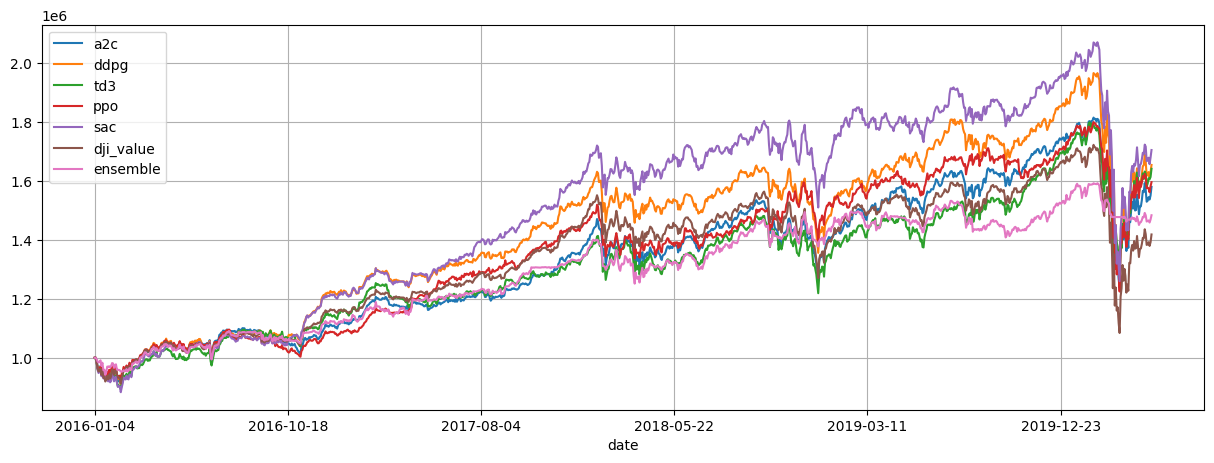

In [102]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
all_values1_index.plot(grid=True);

In [107]:
all_values2 = all_values1.reset_index(inplace=False)
all_values2 = all_values1[(all_values1.date >= '2020-01-01')&(all_values1.date <= '2020-05-08')]
all_values2 = all_values2.set_index('date', inplace=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1500x500 with 0 Axes>

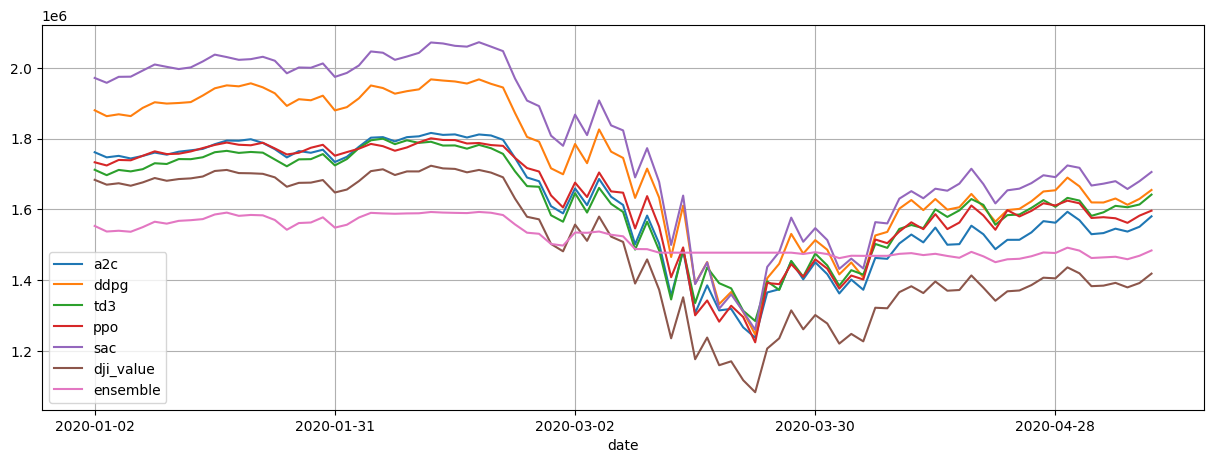

In [108]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
all_values2.plot(grid=True);